In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as pth_transforms
from PIL import Image
import matplotlib.pyplot as plt
import vision_transformer as vits

Processed image shape: torch.Size([1, 3, 480, 480])


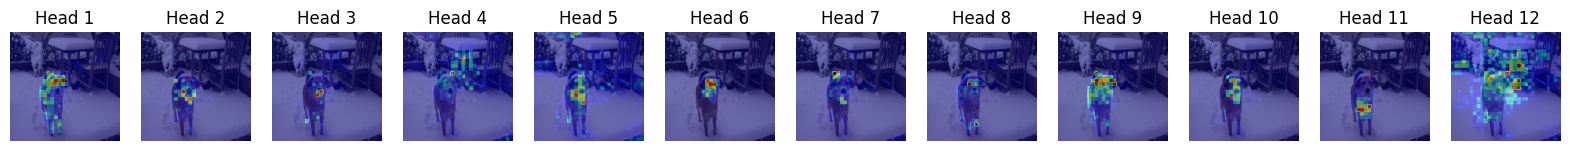

In [3]:

if __name__ == '__main__':

    image_size = (480, 480)  
    patch_size = 16  
    output_dir = '.'

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = vits.vit_base(
        patch_size=patch_size,
        num_classes=0 
    )

    pretrained_weights = 'dino_vitbase16_pretrain.pth' 
    state_dict = torch.load(pretrained_weights, map_location="cpu")
    state_dict = {k.replace("module.", "").replace("backbone.", ""): v for k, v in state_dict.items()}  
    model.load_state_dict(state_dict, strict=False) 

    for p in model.parameters():
        p.requires_grad = False  
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG').convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),

    ])
    img = transform(img)

    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))  

    nh = attentions.shape[1] 
    attentions = attentions[0, :, 0, :]
    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    fig, axs = plt.subplots(1, nh, figsize=(20, 5))
    for i, attn in enumerate(attentions):
        axs[i].imshow(img[0].permute(1, 2, 0).cpu().numpy())  
        axs[i].imshow(attn, cmap="jet", alpha=0.5)  
        axs[i].axis("off")
        axs[i].set_title(f"Head {i + 1}")
    plt.show()



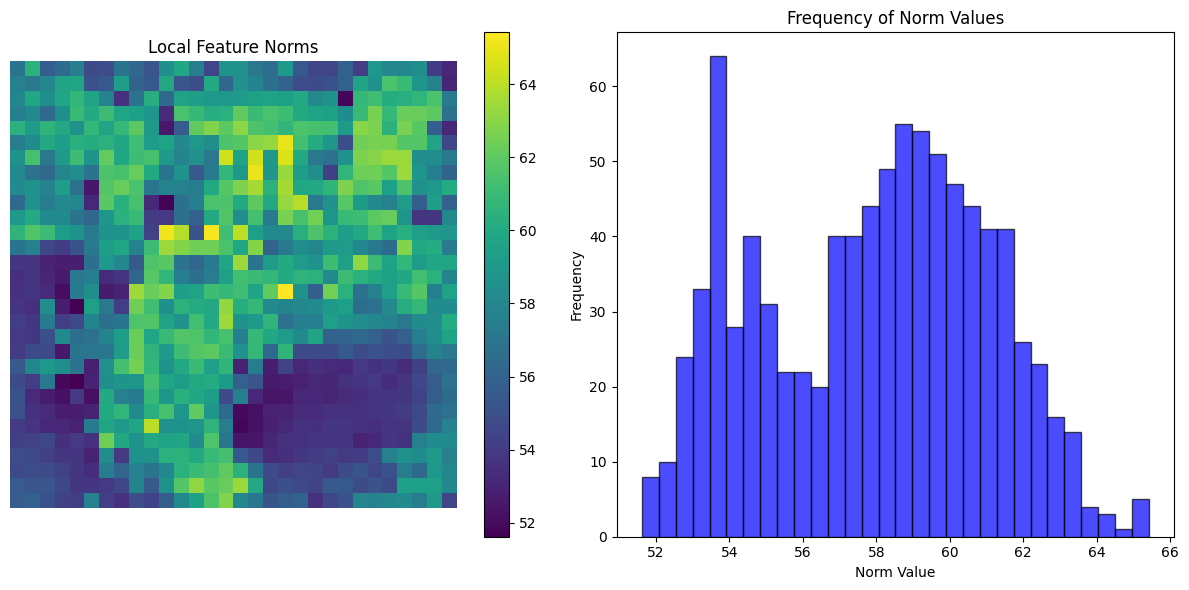

In [13]:
# Extract and visualize feature norms for DINO
with torch.no_grad():
    # Forward pass through the model
    intermediate_features = model.get_intermediate_layers(img.to(device), n=1)  # Get intermediate features (last layer)
    patch_features = intermediate_features[-1][:, 1:, :]  # Exclude the CLS token

    # Compute local feature norms
    local_feature_norms = torch.norm(patch_features, dim=-1)

    # Reshape norms into spatial dimensions
    w_featmap = h_featmap = img.shape[-1] // 16
    local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

    # Flatten norms for histogram
    flattened_norms = local_feature_norms[0].cpu().numpy().flatten()

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot local feature norms
    plt.subplot(1, 2, 1)
    plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
    plt.colorbar()
    plt.title("Local Feature Norms")
    plt.axis("off")

    # Plot histogram of norm values
    plt.subplot(1, 2, 2)
    plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
    plt.title("Frequency of Norm Values")
    plt.xlabel("Norm Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()
